## 作业1：跳伞运动员仿真
   一名高空跳伞运动员从飞机上跳下，能够确定海拔高度和运动员自由下落的速度吗？在上一个实例中，炮弹总是保持$500m/s$的水平初速度（知道落入海中）。实际情况下，空气的摩擦阻力将使炮弹减速。同样，作用在运动员身上的重力同样受到空气摩擦力的影响，并随着运动员速度的增加而变大。最终，这一阻力将导致向上的摩擦力与向下的重力平衡，使合外力为零。在这一点，运动员将不再加速并保持稳态速度。
    根据基本空气动力学理论，运动员所受阻力由下式表示：
$$drag={1\over2}\rho v^2SC_d$$
式中，$\rho$为空气密度，$v$为速度，$S$为表面积，$C_d$为阻力系数。
    该公式的计算显然比较复杂。首先，空气密度$\rho$随着海拔高度而变化；第二，总阻力随着速度的平方变化；第三，运动员的表面积随着其运动而变化；最后，阻力系数取决于运动员伞具采用材料的摩擦力系数。这四个变量都是非线性的，因此很难推导出这个公式的显式解。
    为简化这个问题，假设$\rho=1.225kg/m^3$，$S=1.0m^2$，$C_d=0.05$，因此仅有$v$为非线性项。使用Euler法模拟整个运动过程，而不是直接求解公式。
    改变伞打开的时间，观察跳伞运动员的运动状态变化。

In [682]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

使用State对象存储跳伞运动员每个时刻的速度和所处高度

In [683]:
init = State(V=0,H=8000)

,values
V,0
H,8000


做出如下假设：
1.飞行员的重量为75kg;
2.飞行员的落体时间为1min(60s);
3.飞行员在高度为8000m的海拔处起跳

加入System对象存储系统参数：

In [684]:
Velocity_Height = System(init=init,Rou=1.225,S=1,Cd=0.05,t_00=0,t_0=0,t_end=60,dt=1,m=75,g=9.8)

,values
init,V 0 H 8000 dtype: int64
Rou,1.225
S,1
Cd,0.05
t_00,0
t_0,0
t_end,60
dt,1
m,75
g,9.8


update函数用来表示速度变化：
$$\frac{{dV}}{{dt}} = g - \frac{{\rho {V^2}S{C_d}}}{{2m}}$$
式中，$V$为某一时刻的速度，$t$为时间，$\rho$为空气密度，$v$为速度，$S$为表面积，$C_d$为阻力系数，$m$为飞行员的重量

In [685]:
def update_func(state, t, system):
    
    g , Rou , S , Cd , m , dt = system.g, system.Rou, system.S, system.Cd, system.m, system.dt

    V = state.V
    V += (g - (Rou * S * Cd * V ** 2) / (2 * m)) * dt

    H = state.H
    H -= V * dt

    return State(V=V,H=H)

调用update函数：

In [686]:
update_func(init, 0, Velocity_Height)

,values
V,9.8
H,7990.2


系统仿真函数定义为：

In [687]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

运行仿真：

In [688]:
results = run_simulation(Velocity_Height,update_func)

,V,H
0,0,8000
1,9.8,7990.2
2,19.560784,7970.639216
3,29.204545,7941.434671
4,38.656276,7902.778395
...,...,...
56,154.744021,896.820397
57,154.766188,742.054209
58,154.785554,587.268654
59,154.802473,432.466182


根据上述假设,我们得到了飞行员在起跳开伞情况下的速度变化曲线和高度变化曲线

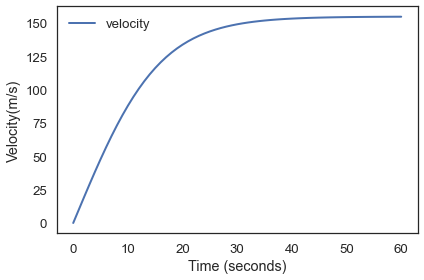

In [689]:
plot(results.V, label='velocity')
decorate(xlabel='Time (seconds)',ylabel='Velocity(m/s)')

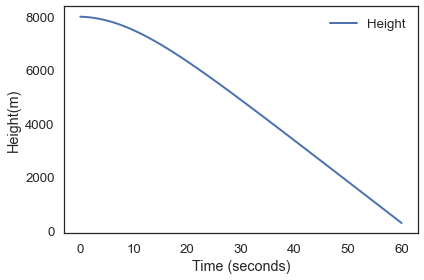

In [690]:
plot(results.H, label='Height')
decorate(xlabel='Time (seconds)',ylabel='Height(m)')

#### 程序封装
让我们定义一个初始化函数：

In [691]:
def make_system(V_init, H_init, t_0):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(V=V_init, H=H_init)
                   
    return System(init=init,
                  Rou=1.225, 
                  S=1,
                  Cd=0.05,
                  m=75,
                  g=9.8,
                  t_00=0,
                  t_0=t_0, 
                  t_end=60, 
                  dt=1)

整个程序可以这样运行：

In [692]:
Velocity_Height = make_system(V_init=0, H_init=8000, t_0=0)
results = run_simulation(Velocity_Height, update_func)
V_final=get_last_value(results.V)
H_final=get_last_value(results.H)
print(V_final)
print(H_final)

154.81725197278556
277.64892955296693


若跳伞运动员在$t_0$秒后才开伞，根据自由落体公式可求得第$t_0$秒时的速度和所处高度：
\begin{array}{l}
{V_0} = g{t_0}\\
H_0 =- \frac{1}{2}gt_0^2
\end{array}

新增update函数

In [693]:
def update_funp(state, t, system):
    g , Rou , S , Cd , m , dt = system.g, system.Rou, system.S, system.Cd, system.m, system.dt

    V = state.V
    V += g * dt

    H = state.H
    H -= V * dt

    return State(V=V,H=H)

重新定义系统仿真函数：

In [694]:
def run_simulation(system, update_func, update_funp):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    init = system.init
    t_00, t_0, t_end, dt = system.t_00, system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_00] = init

    tp = linrange(t_00, t_0, dt)
    
    ts = linrange(t_0, t_end, dt)
    
    for t in tp:
        frame.row[t+dt] = update_funp(frame.row[t], t, system)
    

    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

当$t_0=30s$时的速度和高度曲线为：

In [695]:
Velocity_Height = make_system(V_init=0, H_init=8000, t_0=30)
results = run_simulation(Velocity_Height, update_func, update_funp)

,V,H
0,0,8000
1,9.8,7990.2
2,19.6,7970.6
3,29.4,7941.2
4,39.2,7902.0
...,...,...
56,157.64499,-1321.868455
57,157.297113,-1479.165568
58,156.993974,-1636.159542
59,156.729738,-1792.88928


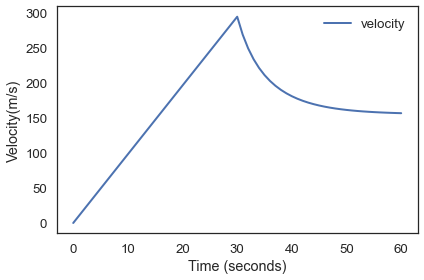

In [696]:
plot(results.V, label='velocity')
decorate(xlabel='Time (seconds)',ylabel='Velocity(m/s)')

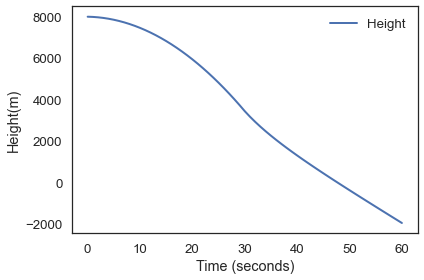

In [697]:
plot(results.H, label='Height')
decorate(xlabel='Time (seconds)',ylabel='Height(m)')

为了得到不同跳伞时间$t_0$下1min后运动员所处的高度，我们编写了如下的函数进行跳伞时间$t_0$进行扫描分析

In [698]:
t0=linrange(0,60,1)
sweep = SweepSeries()
for t in t0:
    Velocity_Height = make_system(V_init=0, H_init=8000, t_0=t)
    results = run_simulation(Velocity_Height, update_func, update_funp)
    H_final=get_last_value(results.H)
    sweep[t] = get_last_value(results.H)

下面是最终仿真结果。

In [702]:
sweep

,values
0,277.648930
1,277.648930
2,277.083338
3,274.944799
4,270.382827
5,262.672917
6,251.192920
7,235.404721
8,214.839869
9,189.088166


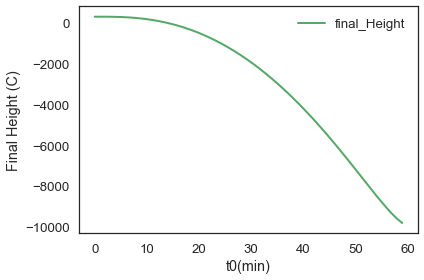

In [701]:
plot(sweep, label='final_Height', color='C2')
decorate(xlabel='t0(min)',
         ylabel='Final Height (C)')

由此可得，当跳伞时间$t0$约为13秒时，可以使得运动员1分钟跳伞后刚好着地